In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm, colors
import seaborn as sns
import statsmodels.api as sm

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn import neighbors
from sklearn.neighbors import NearestNeighbors
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
import sklearn.metrics as metrics
from sklearn.model_selection import KFold
from operator import itemgetter
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.utils import resample
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso 
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from sklearn.ensemble import ExtraTreesClassifier

In [2]:
all_rbs= pd.read_csv('stats/nfl/rbs_for_ai.csv')
all_rbs

,Unnamed: 0,Rk,Player,Year,Age,Draft,Tm,Lg,G,GS,...,RECYds,RECY/R,RECTD,RECY/G,RECCtch%,RECY/Tgt,TotYds,TotTD,TotY/G,MVP
0,0,1,Eric Dickerson*\DickEr00,1984,24,1-2,RAM,NFL,16,16.0,...,139,6.62,0,8.7,NaN,NaN,2244,14,140.3,0
1,1,2,Adrian Peterson\PeteAd01,2012,27,1-7,MIN,NFL,16,16.0,...,217,5.43,1,13.6,78.4%,4.25,2314,13,144.7,1
2,2,3,Jamal Lewis\LewiJa00,2003,24,1-5,BAL,NFL,16,16.0,...,205,7.88,0,12.8,68.4%,5.39,2271,14,141.9,0
3,3,4,Barry Sanders*\SandBa00,1997,29,1-3,DET,NFL,16,16.0,...,305,9.24,3,19.1,66.0%,6.10,2358,14,147.4,1
4,4,5,Terrell Davis*\DaviTe00,1998,26,6-196,DEN,NFL,16,16.0,...,217,8.68,2,13.6,65.8%,5.71,2225,23,139.1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,1495,1496,Tony Baker\BakeTo00,1969,24,NaN,NOR,NFL,14,14.0,...,352,10.35,1,25.1,NaN,NaN,994,2,71.0,0
1496,1496,1497,Correll Buckhalter\BuckCo00,2009,31,4-121,DEN,NFL,14,7.0,...,240,7.74,0,17.1,81.6%,6.32,882,1,63.0,0
1497,1497,1498,Darrin Nelson\NelsDa00,1987,28,1-7,MIN,NFL,10,9.0,...,129,4.96,0,12.9,NaN,NaN,771,2,77.1,0
1498,1498,1499,Darrin Nelson\NelsDa00,1983,24,1-7,MIN,NFL,15,10.0,...,618,12.12,0,41.2,NaN,NaN,1260,1,84.0,0


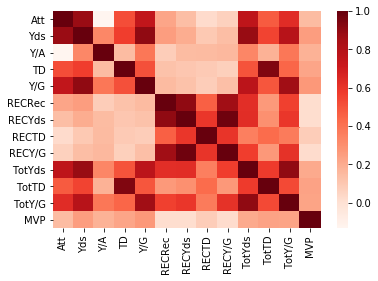

In [3]:
cor = all_rbs[[ 'Att', 'Yds', 'Y/A', 'TD', 'Y/G', 'RECRec','RECYds','RECTD','RECY/G','TotYds','TotTD','TotY/G','MVP' ]].corr()
sns.heatmap(cor, cmap=plt.cm.Reds)
plt.show()

In [4]:
cor_target = abs(cor["MVP"])
relevant_features = cor_target[cor_target>0.15]
relevant_features

Yds       0.252732
Y/A       0.182242
TD        0.228135
Y/G       0.274351
TotYds    0.210309
TotTD     0.234626
TotY/G    0.231031
MVP       1.000000
Name: MVP, dtype: float64

In [32]:
basics = ['Att', 'Yds', 'Y/A', 'TD', 'Y/G', 'RECRec','RECYds','RECTD','RECY/G','TotYds','TotTD','TotY/G']

X_1 = sm.add_constant(X[basics])
model = sm.OLS(y,X_1).fit() # ordinary least squares
model.pvalues # probability value

const     9.763312e-15
Att       1.201270e-42
Yds       4.970947e-05
Y/A       1.543880e-27
TD        4.970947e-05
Y/G       4.970947e-05
RECRec    2.509516e-01
RECYds    4.970947e-05
RECTD     4.970947e-05
RECY/G    4.970947e-05
TotYds    4.970947e-05
TotTD     4.970947e-05
TotY/G    4.970947e-05
dtype: float64

In [6]:
basic_features = ['Yds','Y/A','TD','Y/G','TotYds','TotY/G']

#Resampling
mvp = all_rbs[all_rbs.MVP==1]
non = all_rbs[all_rbs.MVP==0]

mvp_unsampled = resample(mvp, replace=True,n_samples=500,random_state=123)

upsampled = pd.concat([non, mvp_unsampled])
upsampled.MVP.value_counts()
y=upsampled.MVP
X=upsampled.drop('MVP', axis=1)

In [7]:
train, test= train_test_split(all_rbs, test_size = 0.5, random_state = 36)

xtrain = train[['Yds','Y/A','TD','Y/G','TotYds','TotY/G']]
ytrain = train[['MVP']]

xtest = test[['Yds','Y/A','TD','Y/G','TotYds','TotY/G']]
ytest = test[['MVP']]

print("Training set size: %.0f" % len(xtrain))
print("Testing set size: %.0f" % len(xtest))

Training set size: 750
Testing set size: 750


In [29]:
svc2 = SVC(kernel = 'rbf', gamma = 1e-3, C = 100, probability = True)
print('SVC Scores')
yy_svc = scores(svc2)

SVC Scores
Accuracy score: 1.000
Recall: 1.000
Precision: 1.000
F1: 1.000
Log loss: 0.003
Area under ROC curve: 1.000
Accuracy (cross validation score): 0.998 (+/- 0.003)


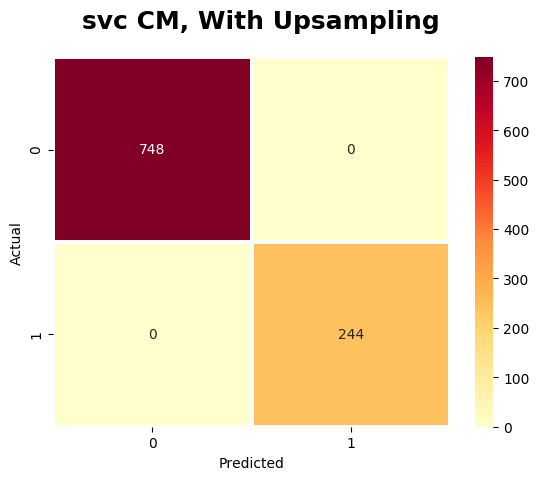

In [31]:
confusion_matrix(yy_svc, 'svc CM, With Upsampling')

In [10]:
train, test = train_test_split(upsampled, test_size = 0.5, random_state = 36)

xtrain = train[['Yds','Y/A','TD','Y/G','TotYds','TotY/G']]
ytrain = train[['MVP']]

xtest = test[['Yds','Y/A','TD','Y/G','TotYds','TotY/G']]
ytest = test[['MVP']]

print("Training set size: %.0f" % len(xtrain))
print("Testing set size: %.0f" % len(xtest))

Training set size: 991
Testing set size: 992


In [27]:
svc = SVC(kernel = 'rbf', gamma = 1e-3, C = 100, probability = True)
print('SVC Scores')
y_svc = scores(svc)

SVC Scores
Accuracy score: 1.000
Recall: 1.000
Precision: 1.000
F1: 1.000
Log loss: 0.003
Area under ROC curve: 1.000
Accuracy (cross validation score): 0.998 (+/- 0.003)


In [12]:
def scores(model):

    model.fit(xtrain, ytrain.values.ravel())
    y_pred = model.predict(xtest)
    
    print("Accuracy score: %.3f" % metrics.accuracy_score(ytest, y_pred))
    print("Recall: %.3f" % metrics.recall_score(ytest, y_pred))
    print("Precision: %.3f" % metrics.precision_score(ytest, y_pred))
    print("F1: %.3f" % metrics.f1_score(ytest, y_pred))
    
    proba = model.predict_proba(xtest)
    print("Log loss: %.3f" % metrics.log_loss(ytest, proba))

    pos_prob = proba[:, 1]
    print("Area under ROC curve: %.3f" % metrics.roc_auc_score(ytest, pos_prob))
    
    cv = cross_val_score(model, xtest, ytest.values.ravel(), cv = 3, scoring = 'accuracy')
    print("Accuracy (cross validation score): %0.3f (+/- %0.3f)" % (cv.mean(), cv.std() * 2))
    
    return y_pred

In [13]:
svc = SVC(kernel = 'rbf', gamma = 1e-3, C = 100, probability = True)
print('SVC Scores')
y_svc = scores(svc)

SVC Scores
Accuracy score: 1.000
Recall: 1.000
Precision: 1.000
F1: 1.000
Log loss: 0.003
Area under ROC curve: 1.000
Accuracy (cross validation score): 0.998 (+/- 0.003)


In [14]:
gbc = GradientBoostingClassifier()
print("GBC Scores")
y_gbc = scores(gbc)

GBC Scores
Accuracy score: 0.990
Recall: 1.000
Precision: 0.961
F1: 0.980
Log loss: 0.037
Area under ROC curve: 0.998
Accuracy (cross validation score): 0.989 (+/- 0.019)


In [15]:
rf = RandomForestClassifier(random_state = 123, n_estimators = 100, criterion = 'gini')
print('RF Scores')
y_rf = scores(rf)

RF Scores
Accuracy score: 0.995
Recall: 1.000
Precision: 0.980
F1: 0.990
Log loss: 0.018
Area under ROC curve: 1.000
Accuracy (cross validation score): 0.990 (+/- 0.016)


In [16]:
def confusion_matrix(y_pred, model_name):
    cm = metrics.confusion_matrix(ytest, y_pred)

    plt.style.use("default")
    z, ax = plt.subplots()

    sns.heatmap(cm, annot=True, ax = ax, linewidth = 2, fmt='g',cmap="YlOrRd")

    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

    z.suptitle("%s" % model_name, weight = 'bold', size = 18, x = .45)

    z.savefig('final_stuff/%s_cm.png' % model_name, dpi = 400, bbox_inches = 'tight')

In [17]:
#Without upsamling
#confusion_matrix(y_svc, 'svc Confusion Matrix, With Upsampling')

In [18]:
#confusion_matrix(y_gbc,'gbc Confusion Matrix, With Upsampling')

In [19]:
def make_pred(model):
    print(model.classes_)
    print('\t\t\t\tNo', '\tYes')
    proba = model.predict_proba(testpredict2020)
    for x in range(len(proba)):
        print(testforpredicts['Player'][x], np.round(proba[x],6)*100)

In [42]:
testforpredicts = pd.read_csv('stats/nfl/tester_for_rbs.csv')
testpredict2020 = testforpredicts[['Yds','Y/A','TD','Y/G','TotYds','TotY/G']]

In [43]:
svcModel = SVC(kernel = 'rbf', gamma = 1e-3, C = 100, probability = True).fit(xtrain, ytrain.values.ravel())

make_pred(svcModel)

[0 1]
				No 	Yes
Adrian Peterson\PeteAd01 [ 0.9801 99.0199]
LaDainian Tomlinson*\TomlLa00 [ 0.982 99.018]
Shaun Alexander\AlexSh00 [ 0.9793 99.0207]
Marshall Faulk*\FaulMa00 [ 0.977 99.023]
Terrell Davis*\DaviTe00 [ 0.979 99.021]
Barry Sanders*\SandBa00 [ 0.9809 99.0191]
Emmitt Smith*\SmitEm00 [ 0.9808 99.0192]
Thurman Thomas*\ThomTh00 [ 0.977 99.023]
Marcus Allen*\AlleMa00 [ 0.9801 99.0199]
Earl Campbell*\CampEa00 [ 0.9819 99.0181]
Walter Payton*\PaytWa00 [ 0.9785 99.0215]


In [44]:
model = GradientBoostingClassifier().fit(xtrain, ytrain.values.ravel())

make_pred(model)


[0 1]
				No 	Yes
Adrian Peterson\PeteAd01 [ 0.5344 99.4656]
LaDainian Tomlinson*\TomlLa00 [ 0.2241 99.7759]
Shaun Alexander\AlexSh00 [ 0.6465 99.3535]
Marshall Faulk*\FaulMa00 [ 0.6373 99.3627]
Terrell Davis*\DaviTe00 [ 0.62 99.38]
Barry Sanders*\SandBa00 [ 0.7747 99.2253]
Emmitt Smith*\SmitEm00 [ 2.0825 97.9175]
Thurman Thomas*\ThomTh00 [ 2.7453 97.2547]
Marcus Allen*\AlleMa00 [ 1.0149 98.9851]
Earl Campbell*\CampEa00 [ 1.1767 98.8233]
Walter Payton*\PaytWa00 [ 1.3023 98.6977]


In [45]:
model = RandomForestClassifier(random_state = 123, n_estimators = 1000, criterion = 'gini').fit(xtrain,ytrain.values.ravel())

make_pred(model)

[0 1]
				No 	Yes
Adrian Peterson\PeteAd01 [  0. 100.]
LaDainian Tomlinson*\TomlLa00 [  0. 100.]
Shaun Alexander\AlexSh00 [  0. 100.]
Marshall Faulk*\FaulMa00 [  0. 100.]
Terrell Davis*\DaviTe00 [  0. 100.]
Barry Sanders*\SandBa00 [  0. 100.]
Emmitt Smith*\SmitEm00 [  0. 100.]
Thurman Thomas*\ThomTh00 [  0. 100.]
Marcus Allen*\AlleMa00 [  0. 100.]
Earl Campbell*\CampEa00 [  0. 100.]
Walter Payton*\PaytWa00 [  0. 100.]


In [54]:
# Multi-layer Perceptron classifier.
# Depends on alpha value
#https://scikit-learn.org/stable/_images/sphx_glr_plot_mlp_alpha_001.png
model = MLPClassifier(solver = 'adam', hidden_layer_sizes = 65, random_state = 123, activation = 'relu',alpha=5).fit(xtrain, ytrain.values.ravel())
make_pred(model)

[0 1]
				No 	Yes
Adrian Peterson\PeteAd01 [ 5.7883 94.2117]
LaDainian Tomlinson*\TomlLa00 [ 1.501 98.499]
Shaun Alexander\AlexSh00 [ 0.1006 99.8994]
Marshall Faulk*\FaulMa00 [23.5417 76.4583]
Terrell Davis*\DaviTe00 [ 0.9523 99.0477]
Barry Sanders*\SandBa00 [18.7935 81.2065]
Emmitt Smith*\SmitEm00 [40.7245 59.2755]
Thurman Thomas*\ThomTh00 [36.6946 63.3054]
Marcus Allen*\AlleMa00 [18.5833 81.4167]
Earl Campbell*\CampEa00 [ 0.7608 99.2392]
Walter Payton*\PaytWa00 [ 8.9388 91.0612]


In [40]:
dtc =  DecisionTreeClassifier(max_depth=5).fit(xtrain,ytrain.values.ravel())

make_pred(dtc)

[0 1]
				No 	Yes
Adrian Peterson\PeteAd01 [ 6.1321 93.8679]
LaDainian Tomlinson*\TomlLa00 [ 6.1321 93.8679]
Shaun Alexander\AlexSh00 [  0. 100.]
Marshall Faulk*\FaulMa00 [ 6.1321 93.8679]
Terrell Davis*\DaviTe00 [ 6.1321 93.8679]
Barry Sanders*\SandBa00 [ 6.1321 93.8679]
Emmitt Smith*\SmitEm00 [ 6.1321 93.8679]
Thurman Thomas*\ThomTh00 [ 6.1321 93.8679]
Marcus Allen*\AlleMa00 [ 6.1321 93.8679]
Earl Campbell*\CampEa00 [  0. 100.]
Walter Payton*\PaytWa00 [ 6.1321 93.8679]
Derrick Henry\HenrDe00 [100.   0.]


In [41]:
# Not great for this data set

nbrs = NearestNeighbors(n_neighbors=2,algorithm='ball_tree').fit(xtrain,ytrain.values.ravel())

make_pred(dtc)

[0 1]
				No 	Yes
Adrian Peterson\PeteAd01 [ 6.1321 93.8679]
LaDainian Tomlinson*\TomlLa00 [ 6.1321 93.8679]
Shaun Alexander\AlexSh00 [  0. 100.]
Marshall Faulk*\FaulMa00 [ 6.1321 93.8679]
Terrell Davis*\DaviTe00 [ 6.1321 93.8679]
Barry Sanders*\SandBa00 [ 6.1321 93.8679]
Emmitt Smith*\SmitEm00 [ 6.1321 93.8679]
Thurman Thomas*\ThomTh00 [ 6.1321 93.8679]
Marcus Allen*\AlleMa00 [ 6.1321 93.8679]
Earl Campbell*\CampEa00 [  0. 100.]
Walter Payton*\PaytWa00 [ 6.1321 93.8679]
Derrick Henry\HenrDe00 [100.   0.]
